In [61]:
import glob
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord 
import astropy.units as u
import matplotlib.pyplot as plt
import skimage.transform as skt
from astropy.visualization import ZScaleInterval
from photutils.aperture import CircularAperture
import numpy as np
from RetrieveSource import *

# Grab File

In [8]:
############
# Get File #
############

def get_file(id,segment=1,extension=1,filter='um2'):
    file_location = "Data"
    labels = ['RAhr','DEdeg','Umag','e_Umag','Bmag','e_Bmag','Vmag','e_Vmag','Imag','e_Imag','Flag','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag']
    fname = glob.glob(f"{file_location}/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.new")
    cname = glob.glob(f"{file_location}/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.full.dat")
    HDR = fits.open(fname[0])
    CAT = pd.read_csv(cname[0],delimiter='\s+',names=labels)
    return HDR, CAT, cname

def plot_file(id,segment=1,extension=1,filter='um2',xdim=None,ydim=None):   
    Z = ZScaleInterval()
    HDR,CAT,cname = get_file(id,segment=1,extension=1,filter='um2')
    data = HDR[0].data
    if xdim == None:
        vmin,vmax = Z.get_limits(data)
    else:
        vmin,vmax = Z.get_limits(data[ydim[0]:ydim[1],xdim[0]:xdim[1]])
    f= plt.figure(figsize=(10,10))
    plt.imshow(data,origin='lower',vmin=vmin,vmax=vmax)
    plt.xlim(xdim)
    plt.ylim(ydim)
    
def get_pixel_coordinates(HDR,CAT):
    co = SkyCoord(CAT['RAhr'],CAT['DEdeg'],unit=(u.hourangle,u.deg))
    x,y = co.to_pixel(WCS(HDR[0].header))
    CAT['X'] = x
    CAT['Y'] = y
    return x,y 

def reformat_pixel_coordinates(x,y):
    # If you need coordinates as integers or need to move from edges at all
    x_co = np.array([int(np.round(x_)) for x_ in X[Y<1312]])
    y_co = np.array([int(np.round(y_)) for y_ in Y[Y<1312]])
    return x_co,y_co

def get_data(id) :
    HDR,CAT,cname = get_file(id,segment=1,extension=1,filter='um2')
    return HDR[0].data

# Look at Files

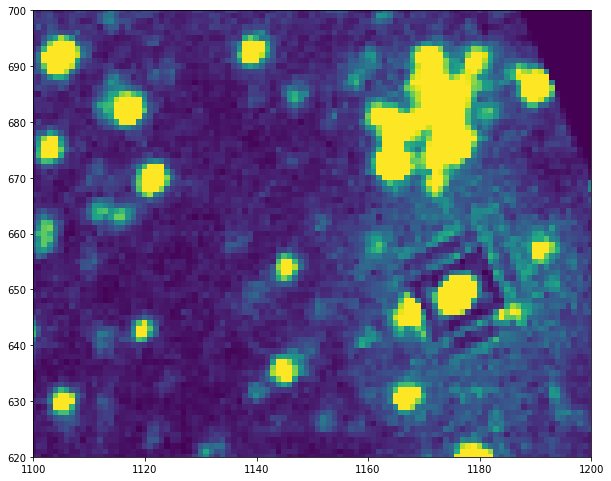

In [7]:
plot_file(40416,xdim=[1100,1200],ydim=[620,700])

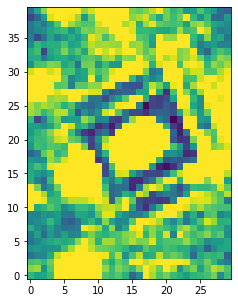

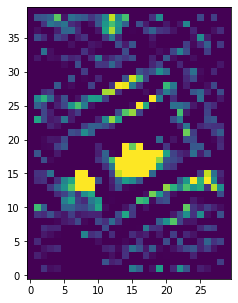

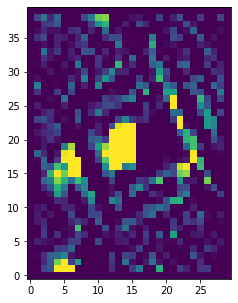

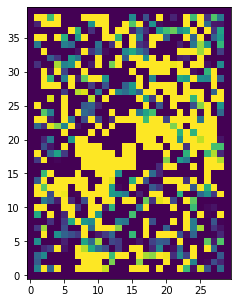

In [115]:
# Attempt Number 1 - find edges by computing derivatives, in theory the lapacian should be a measure
# of the curvature and the troughs around the detection should be identifiable.
# 
# Results - did not work at all. Nothing seems particularly identifiable in the derivative images.

data = get_data(40416);
data = data[630:670,1160:1190];

def sane_plot(data) : 
    f= plt.figure(figsize=(5,5))
    plt.imshow(data, origin='lower', vmin=0, vmax=15);

def eval(x,y) :
    return data[x,y];

def dfx(x,y) : 
    return eval(x+1,y)-eval(x,y)
def dfy(x,y) : 
    return eval(x,y+1)-eval(x,y)
def dfx2(x,y) :
    return eval(x+1,y)-2*eval(x,y)+eval(x-1,y);
def dfy2(x,y) :
    return eval(x,y+1)-2*eval(x,y)+eval(x,y-1);
def dfxdfy(x,y) :
    return (eval(x+1,y)-eval(x,y))*(eval(x,y+1)-eval(x,y));

def compute(functor) :
    # First coordinate is x, second coordinate is y
    xWidth = data.shape[0]
    yWidth = data.shape[1]
    testData = np.zeros(data.shape);
    
    for x in range(xWidth) :
        for y in range(yWidth) : 
            if (x == 0 or x == xWidth-1 or y == 0 or y == yWidth -1) : 
                testData[x,y] = 0;
                continue;
            testData[x, y] = functor(x,y);
            
    return testData

def computeXDerivative() : 
    return compute(dfx);

def computeYDerivative() : 
    return compute(dfy);

def computeLaplacian() : 
    return compute(lambda x,y : dfx2(x,y) +2*dfxdfy(x,y)+dfy2(x,y));

sane_plot(data)
sane_plot(computeXDerivative())
sane_plot(computeYDerivative())
sane_plot(computeLaplacian())

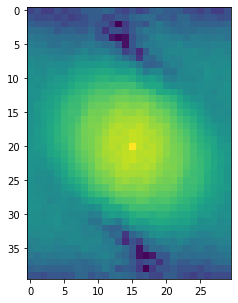

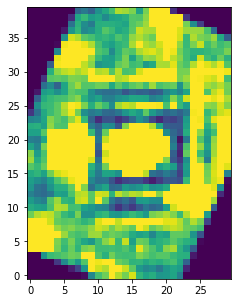

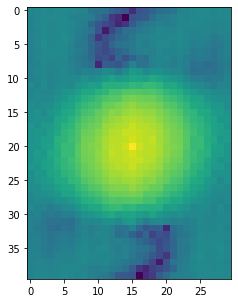

In [114]:
# Attempt Number 2 - try out some Fourier Transforms to see if identifying the lines is easier in frequeny space.
# 
# Results - didn't really work at all. But I noticed the lines of the distortions seem to line up with the edges of the image.
# This is presumably due to some aspect of the detector's orientation, however it might be useful in identifying the lines.
# Below I manually rotated the image until the axes were 'lined up' with x & y, then applied the same angle transform
# to this smaller region, and noticed the distortion troughs are now well aligned with x & y. Could be useful

data = get_data(40416);
data = data[630:670,1160:1190];

fourier_data = np.fft.fftshift(np.fft.fft2(data));
plt.figure(figsize=(5,5))
plt.imshow(np.log(abs(fourier_data)))

rotatedData = skt.rotate(skimage.util.img_as_float64(data),24);
sane_plot(rotatedData)

data = rotatedData;
fourier_data = np.fft.fftshift(np.fft.fft2(data));
plt.figure(figsize=(5,5))
plt.imshow(np.log(abs(fourier_data)))


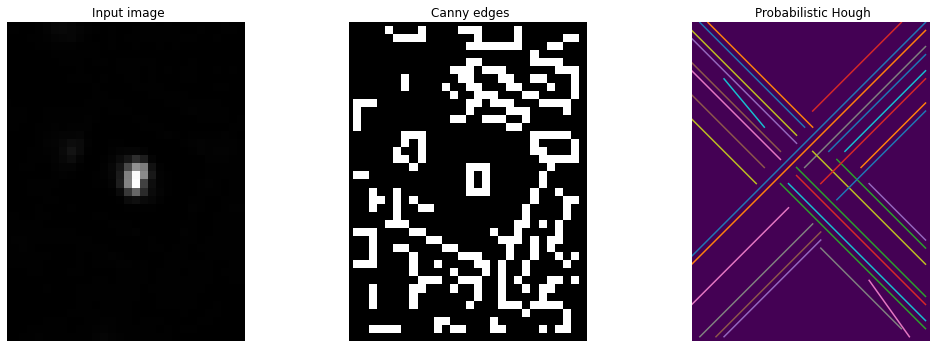

In [104]:
# Attempt Number 3 - try out some of skimage's built-in line detection algorithms.
# The Hough Transform seems popular for this type of problem, but usually on cleaner data.
#
# Results - did not work at all. I think this is largely due to not finding the right normalization for the data.
# The parameters in the line detection seem pretty sensitive to their threshold and other properties which
# are not particularly well documented at https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.probabilistic_hough_line

from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from matplotlib import cm
data = get_data(40416);
data = data[630:670,1160:1190];

edges = canny(data)
lines = probabilistic_hough_line(data, threshold=50,line_length=5, line_gap=0)

#fourier_data = np.fft.fftshift(np.fft.fft2(data));
#plt.figure(figsize=(5,5))
#plt.imshow(np.log(abs(fourier_data)))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, data.shape[1]))
ax[2].set_ylim((data.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

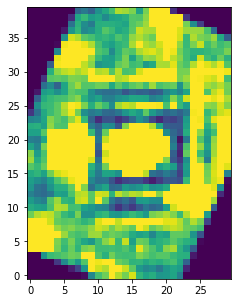

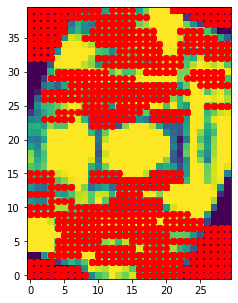

In [157]:
# Attempt Number 4 - write a quick and dirty line detection algorithm.
#
# Results - could maybe work with more effort. Haven't found the best way to tune the threshold & minimum line length yet.
# Currently it identifies a lot of the regular data as being in a line, probably the next step would be to add some constraints
# to make sure the line is in a trough rather than just some similarly valued data.
#

def sane_plot(data) : 
    f= plt.figure(figsize=(5,5))
    plt.imshow(data, origin='lower', vmin=0, vmax=15);

data = get_data(40416);
data = data[630:670,1160:1190];
data = skt.rotate(skimage.util.img_as_float64(data),24);

sane_plot(data)

def eval(x,y) :
    return data[x,y];

def find_line(x, y, threshold) : 
    x_coords = [x];
    y_coords = [y];
    x_initial = x;
    y_initial = y;
    
    # Starting at (x,y) try to extend to the left and right until we hit the edge or the value exceeds our threshold
    # Go right
    while True : 
        if y+1 < 0 or y+1 >= np.shape(data)[1]:
            break;
        
        if abs(eval(x,y+1)-eval(x_initial,y_initial)) < threshold :
            # Accept
            y = y+1;
            x_coords.append(x);
            y_coords.append(y);
        else :
            break;
    # Reset to initial coordinates and go the other direction
    x = x_initial;
    y = y_initial;
    while True :
        if y-1 < 0 or y-1 >= np.shape(data)[1]:
            break;
        
        if abs(eval(x,y-1)-eval(x_initial,y_initial)) < threshold :
            # Accept
            y = y-1;
            x_coords.append(x);
            y_coords.append(y);
        else :
            break;
            
    return x_coords, y_coords;

sane_plot(data)

min_length = 4;

lines = [];
for i in range(np.shape(data)[0]) : 
    for j in range(np.shape(data)[1]) : 
        xs, ys = find_line(i,j, 2);
        if len(xs) >= min_length :
            lines.append((xs,ys))

for i in range(len(lines)):
    plt.scatter(lines[i][1],lines[i][0],c='r')

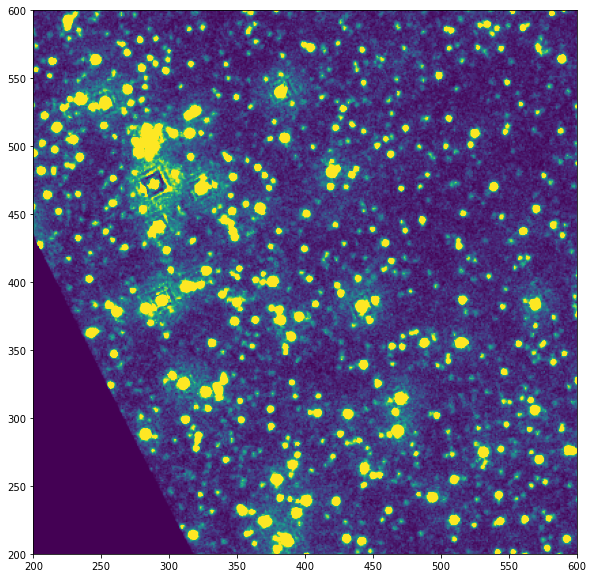

In [103]:
plot_file(40417,xdim=[200,600],ydim=[200,600])

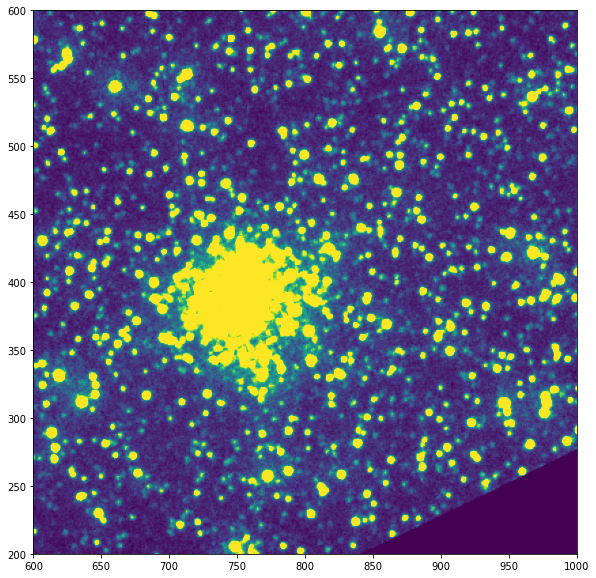

In [5]:
plot_file(40419,xdim=[600,1000],ydim=[200,600])

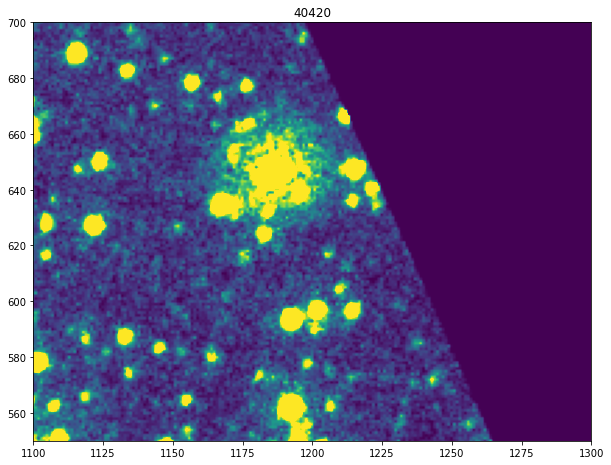

In [23]:
plot_file(40420,xdim=[1100,1300],ydim=[550,700])

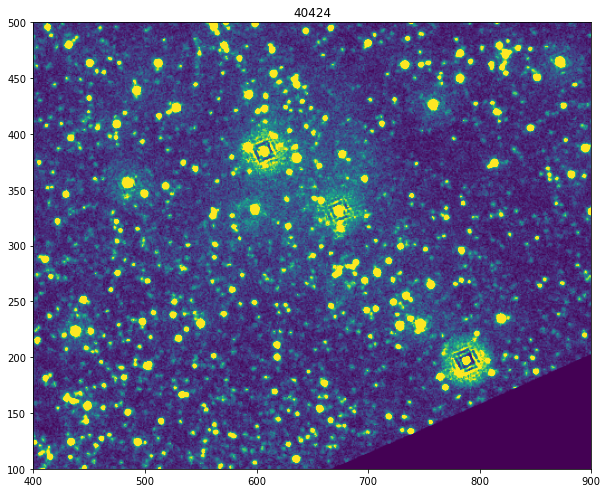

In [24]:
plot_file(40424,xdim=[400,900],ydim=[100,500])

# Idea 1: Do aperture photometry and look at highest count sources.

Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


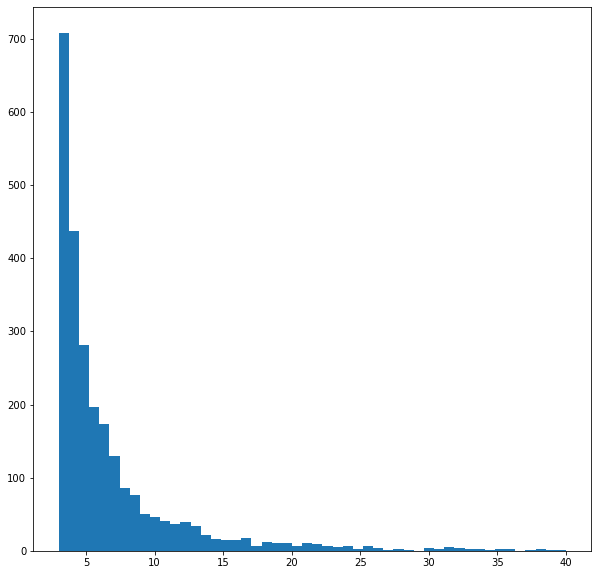

In [35]:
# Pick your favorite file
HDR,CAT,CAT_File_Name = get_file(40415)
data = HDR[0].data

# Get Photometry from Retrieve Source
r,c = np.shape(HDR[0])
meta = get_meta().with_hdu(HDR[0],
                           optical_catalog=CAT_File_Name[0],
                           xdim=[0,r],
                           ydim=[0,c])

init_phot_full = meta.source_intensities
init_phot = init_phot_full[(init_phot_full != 0) & (~np.isnan(init_phot_full)) ]

plt.figure(figsize=(10,10))
plt.hist(init_phot,bins=50,range=(3,40));

(600.0, 800.0)

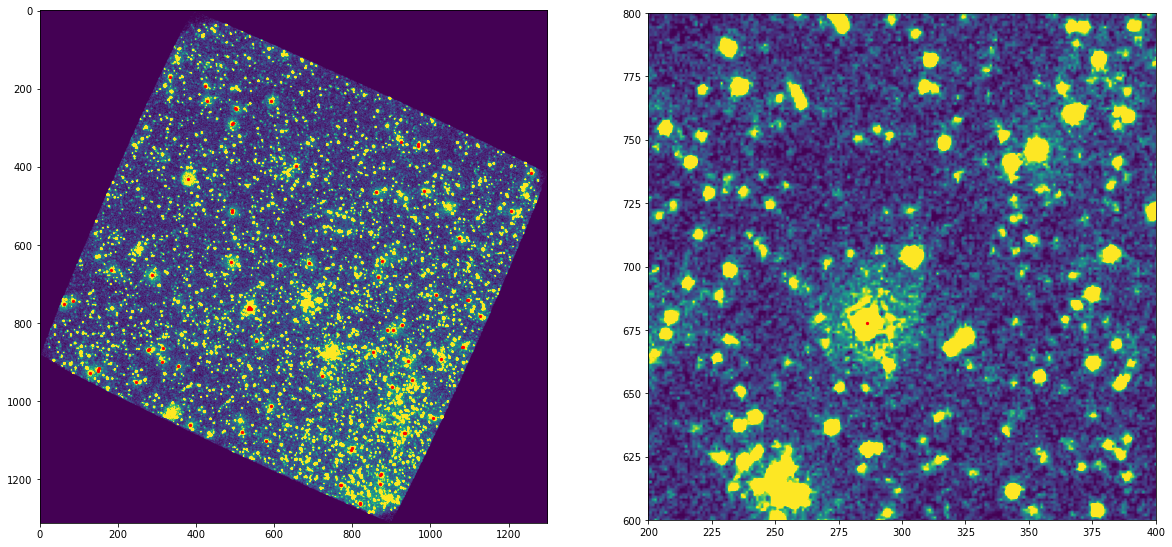

In [36]:
# Pick a threshhold where you want to select out bright things
threshhold = 25

x,y = meta.pixel_positions
x = x[(init_phot_full != 0) & (~np.isnan(init_phot_full)) & (init_phot_full > threshhold)]
y = y[(init_phot_full != 0) & (~np.isnan(init_phot_full)) & (init_phot_full > threshhold)]

# Plot what would be removed if you went with this thresshold. 
Z = ZScaleInterval()
vmin,vmax = Z.get_limits(data)
f,axes=plt.subplots(1,2,figsize=(20,10))    
axes[0].imshow(data,vmin=vmin,vmax=vmax)
axes[1].imshow(data,vmin=vmin,vmax=vmax)
[ax.scatter(x,y,s=5,c='r') for ax in axes]
axes[1].set_xlim(200,400)
axes[1].set_ylim(600,800)